In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

np.random.sample(1337)

data_path = '/content/drive/MyDrive/SolarGen/'

## Baseline

In [ ]:
df_train = pd.read_csv(data_path + './data/train/train.csv')
submission = pd.read_csv(data_path + './data/sample_submission.csv')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, 
    MaxAbsScaler, PowerTransformer
)

class ScalingFactor:
    def __init__(self, scaler, features):
        self.scaler = scaler
        self.features = features

def scaling(data, scaler, features, is_train=True):

    temp = data.copy()

    target_cols = features
    temp = temp[target_cols]
    if is_train: 
        scaler.fit(temp)
    scaled = scaler.transform(temp)

    data[target_cols] = scaled

    return data

def slicing_data(data, window_size):

    slices = []

    for i in range(len(data) - window_size):
        slices.append(np.array(data[i:i+window_size]))

    return np.array(slices)

def preprocess_data(data, scale_factors, window_size, is_train=True):
    
    temp = data.copy()

    for factor in scale_factors:
        temp = scaling(temp, factor.scaler, factor.features, is_train)

    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
    temp_np = temp.to_numpy()

    if is_train==True:          
    
        temp = slicing_data(temp_np, window_size)
        
        return temp[:-96]

    elif is_train==False:

        temp = slicing_data(temp_np, window_size)
                              
        return temp[-1]

scale_factors = []
scale_factors.append(ScalingFactor(PowerTransformer(), ['DHI', 'DNI']))
# scale_factors.append(ScalingFactor(QuantileTransformer(output_distribution='normal'), ['DNI']))
scale_factors.append(ScalingFactor(StandardScaler(), ['WS', 'RH', 'T']))
scale_factors.append(ScalingFactor(MinMaxScaler(), ['DHI', 'DNI', 'WS', 'RH', 'T']))

window_size = 48
train = preprocess_data(df_train, scale_factors, window_size)
train_label = slicing_data(df_train.iloc[window_size:]['TARGET'], 96)

# train[0].iloc[:, 1:].plot(subplots=True, layout=(1,6), figsize=(30,4))
# train[0].iloc[:, 1:].hist(bins = 100, layout=(1,6), figsize=(30,4))
train.shape, train_label.shape

((52416, 48, 7), (52416, 96))

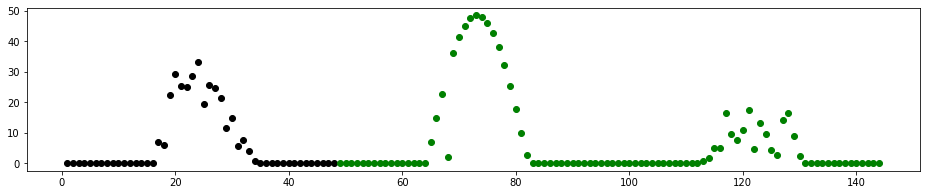

In [ ]:
nth_data = 0
fig, ax = plt.subplots(figsize=(16,3))
ax.scatter([i+1 for i in range(48)], train[nth_data][:,1], color='k')
ax.scatter([i+49 for i in range(96)], train_label[nth_data], color='g')

In [ ]:
test = []

for i in range(81):
    file_path = data_path + './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, scale_factors, window_size, is_train=False)
    test.append(temp)

# X_test[0].iloc[:, 1:].plot(subplots=True, layout=(1,6), figsize=(30,4))
# X_test[0].iloc[:, 1:].hist(bins = 100, layout=(1,6), figsize=(30,4))

X_test = np.array(test)
X_test.shape

(81, 48, 7)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(train, train_label, test_size=0.3, random_state=0, shuffle=False)

X_train.shape, Y_train.shape

((36691, 48, 7), (36691, 96))

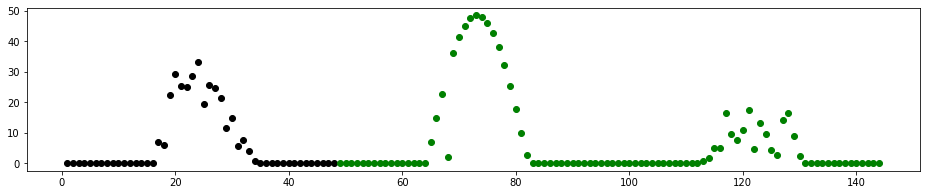

In [ ]:
nth_data = 0
fig, ax = plt.subplots(figsize=(16,3))
ax.scatter([i+1 for i in range(48)], X_train[nth_data][:,1], color='k')
ax.scatter([i+49 for i in range(96)], Y_train[nth_data], color='g')

In [ ]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
from tensorflow.keras.layers import LSTM, Dense

rnn_layer = 48
hidden_layer = 96

models = []

def ploss(q):

    def pinball_loss(y_true, y_pred):
        error = y_true - y_pred
        return K.mean(K.maximum(q*error, (q-1)*error), axis=-1)

    return pinball_loss

for q in quantiles:
    rnn = tf.keras.Sequential()
    rnn.add(LSTM(rnn_layer, input_shape=X_train[0].shape))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(Y_train[0].shape[0]))
    rnn.compile(loss=ploss(q=q), optimizer='adam')
    models.append(rnn)

# rnn = tf.keras.Sequential()
# rnn.add(LSTM(rnn_layer, input_shape=X_train[0].shape))
# rnn.add(Dense(hidden_layer, activation='relu'))
# rnn.add(Dense(hidden_layer, activation='relu'))
# rnn.add(Dense(hidden_layer, activation='relu'))
# rnn.add(Dense(hidden_layer, activation='relu'))
# rnn.add(Dense(hidden_layer, activation='relu'))
# rnn.add(Dense(Y_train[0].shape[0]))
# rnn.compile(loss=ploss(q=0.5), optimizer='adam')
# models.append(rnn)

models[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48)                10752     
_________________________________________________________________
dense (Dense)                (None, 96)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_4 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_5 (Dense)              (None, 96)                9

In [ ]:
batch_size = 128
epochs = 200

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

for index, model in enumerate(models):
    print("[Q = %.1f]"%((index+1)*0.1))
    best_model = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SolarGen/model/best_%d.h5'%((index+1)), 
                                                monitor='val_loss', verbose=1, save_best_only=True)
    model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=epochs, 
              batch_size=batch_size, callbacks=[early_stopping, best_model])

[Q = 0.1]
Epoch 1/200
287/287 [==============================] - 5s 8ms/step - loss: 1.7512 - val_loss: 1.8634

Epoch 00001: val_loss improved from inf to 1.86336, saving model to /content/drive/MyDrive/SolarGen/model/best_1.h5
Epoch 2/200
287/287 [==============================] - 2s 6ms/step - loss: 1.7525 - val_loss: 1.8634

Epoch 00002: val_loss improved from 1.86336 to 1.86335, saving model to /content/drive/MyDrive/SolarGen/model/best_1.h5
Epoch 3/200
287/287 [==============================] - 2s 6ms/step - loss: 1.7482 - val_loss: 1.8634

Epoch 00003: val_loss did not improve from 1.86335
Epoch 4/200
287/287 [==============================] - 2s 6ms/step - loss: 1.7459 - val_loss: 1.8634

Epoch 00004: val_loss did not improve from 1.86335
Epoch 5/200
287/287 [==============================] - 2s 6ms/step - loss: 1.7508 - val_loss: 1.8634

Epoch 00005: val_loss improved from 1.86335 to 1.86335, saving model to /content/drive/MyDrive/SolarGen/model/best_1.h5
Epoch 6/200
287/287 [=

In [ ]:
losses = []

for index in range(9):
    print('[best_%d.h5]'%((index+1)))
    model = tf.keras.models.load_model('/content/drive/MyDrive/SolarGen/model/best_%d.h5'%((index+1)),
                                    custom_objects={'pinball_loss': ploss((index+1)*0.1)})
    losses.append(model.evaluate(X_valid, Y_valid))

np.average(losses)

[best_1.h5]
492/492 [==============================] - 2s 3ms/step - loss: 1.8633
[best_2.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.4001
[best_3.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.9420
[best_4.h5]
492/492 [==============================] - 2s 3ms/step - loss: 3.0568
[best_5.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.9498
[best_6.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.6084
[best_7.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.0564
[best_8.h5]
492/492 [==============================] - 2s 2ms/step - loss: 1.4751
[best_9.h5]
492/492 [==============================] - 2s 3ms/step - loss: 0.7698


2.2357559667693243

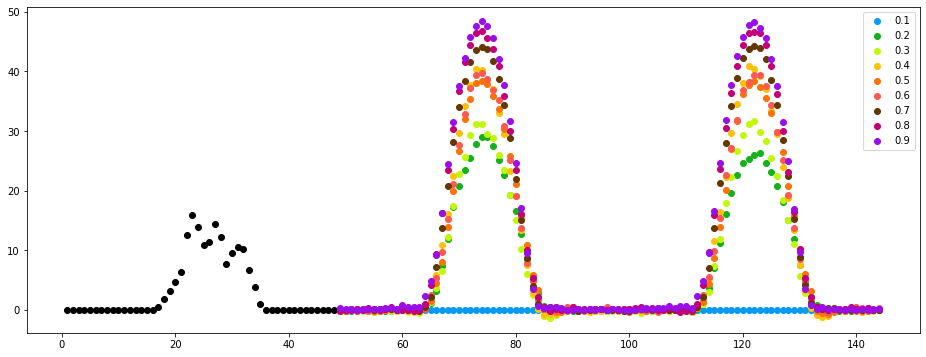

In [ ]:
import matplotlib._color_data as mcd

nth_data = 0
fig, ax = plt.subplots(figsize=(16,6))
ax.scatter([i+1 for i in range(48)], X_test[nth_data][:,1], color='k')
colors = ["xkcd:azure", "xkcd:green", "xkcd:chartreuse", "xkcd:goldenrod",
          "xkcd:orange", "xkcd:coral", "xkcd:brown", "xkcd:magenta", "xkcd:violet"]
for index in range(9):
    model = tf.keras.models.load_model('/content/drive/MyDrive/SolarGen/model/best_%d.h5'%((index+1)),
                                       custom_objects={'pinball_loss': ploss((index+1)*0.1)})
    color =  colors[index]
    ax.scatter([i+49 for i in range(96)], model.predict(np.array([X_test[nth_data]])), color=color, label="%.1f"%((index+1)*0.1))
    ax.legend()

In [ ]:
results = pd.DataFrame()

for index in range(9):
    model = tf.keras.models.load_model('/content/drive/MyDrive/SolarGen/model/best_%d.h5'%((index+1)),
                                       custom_objects={'pinball_loss': ploss((index+1)*0.1)})
    pred = pd.Series(np.reshape(model.predict(X_test), -1))
    results = pd.concat([results, pred], axis=1)

results.columns = quantiles
results

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,-0.000108,-0.136758,-0.127931,-0.096287,0.019012,0.178266,0.014106,-0.147405,0.241713
1,-0.000189,-0.159858,-0.170222,-0.136322,-0.150934,-0.163449,0.019843,-0.034632,0.170561
2,0.000071,-0.151476,-0.049641,0.146293,0.059896,0.052473,0.129364,0.050242,0.155918
3,-0.000019,-0.177667,-0.037433,0.179424,0.201104,-0.201783,0.046031,0.064706,0.056583
4,-0.000251,-0.036081,-0.147688,-0.045906,0.030760,0.013507,0.085757,0.015464,0.166180
...,...,...,...,...,...,...,...,...,...
7771,-0.000543,-0.223759,-0.069612,0.071423,-0.066105,0.813045,0.142831,0.321077,0.144181
7772,0.000151,0.025949,0.194624,0.096082,-0.225828,0.732904,-0.095150,0.389211,0.455601
7773,-0.000323,-0.007828,-0.301520,0.325302,-0.193202,1.117994,-0.055588,0.317578,0.032077
7774,0.000003,-0.044355,0.208805,-0.057041,-0.232449,0.524589,0.010492,0.078237,0.281101


In [ ]:
results = results.clip(0.0)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.000000,0.000000,0.000000,0.000000,0.019012,0.178266,0.014106,0.000000,0.241713
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019843,0.000000,0.170561
2,0.000071,0.000000,0.000000,0.146293,0.059896,0.052473,0.129364,0.050242,0.155918
3,0.000000,0.000000,0.000000,0.179424,0.201104,0.000000,0.046031,0.064706,0.056583
4,0.000000,0.000000,0.000000,0.000000,0.030760,0.013507,0.085757,0.015464,0.166180
5,0.000000,0.000000,0.000000,0.000000,0.112290,0.000000,0.171906,0.261115,0.066363
6,0.000000,0.000000,0.000000,0.000000,0.130518,0.000000,0.000000,0.084246,0.089338
7,0.000000,0.000000,0.000000,0.000000,0.122735,0.000000,0.082931,0.000000,0.210678
8,0.000000,0.000000,0.000000,0.000000,0.130092,0.060007,0.151717,0.092596,0.248175
9,0.000000,0.000000,0.000000,0.000000,0.233418,0.120211,0.140941,0.517957,0.392665


In [ ]:
submission.iloc[:, 1:] = results.values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.019012,0.178266,0.014106,0.000000,0.241713
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019843,0.000000,0.170561
2,0.csv_Day7_1h00m,0.000071,0.000000,0.000000,0.146293,0.059896,0.052473,0.129364,0.050242,0.155918
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.179424,0.201104,0.000000,0.046031,0.064706,0.056583
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.030760,0.013507,0.085757,0.015464,0.166180
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.000000,0.000000,0.000000,0.071423,0.000000,0.813045,0.142831,0.321077,0.144181
7772,80.csv_Day8_22h00m,0.000151,0.025949,0.194624,0.096082,0.000000,0.732904,0.000000,0.389211,0.455601
7773,80.csv_Day8_22h30m,0.000000,0.000000,0.000000,0.325302,0.000000,1.117994,0.000000,0.317578,0.032077
7774,80.csv_Day8_23h00m,0.000003,0.000000,0.208805,0.000000,0.000000,0.524589,0.010492,0.078237,0.281101


In [ ]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.019012,0.178266,0.014106,0.000000,0.241713
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019843,0.000000,0.170561
2,0.csv_Day7_1h00m,0.000071,0.000000,0.000000,0.146293,0.059896,0.052473,0.129364,0.050242,0.155918
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.179424,0.201104,0.000000,0.046031,0.064706,0.056583
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.030760,0.013507,0.085757,0.015464,0.166180
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.112290,0.000000,0.171906,0.261115,0.066363
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.130518,0.000000,0.000000,0.084246,0.089338
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.122735,0.000000,0.082931,0.000000,0.210678
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.130092,0.060007,0.151717,0.092596,0.248175
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.233418,0.120211,0.140941,0.517957,0.392665


In [ ]:
# submission.to_csv(data_path + './data/submission.csv', index=False)